# Credit Risk Resampling Techniques

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

# Read the CSV and Perform Basic Data Cleaning

In [14]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [15]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

df['loan_status'].unique()

array(['Current', 'In Grace Period', 'Late (16-30 days)',
       'Late (31-120 days)'], dtype=object)

In [16]:
# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [17]:
df.select_dtypes(include=[object]).tail()

,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
68812,RENT,Source Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
68813,RENT,Not Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
68814,MORTGAGE,Source Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
68815,MORTGAGE,Verified,Jan-2019,low_risk,n,f,May-2019,Individual,N,N
68816,MORTGAGE,Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N


In [18]:
df_encoded = pd.get_dummies(df, columns=["home_ownership", "pymnt_plan", "verification_status", "issue_d", "next_pymnt_d", "initial_list_status", "application_type", "hardship_flag", "debt_settlement_flag"]).copy()
df_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Jan-2019,issue_d_Mar-2019,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,0,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,0,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,0,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,0,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,0,1,0,1,0,1,1,0,1,1


# Split the Data into Training and Testing

In [19]:
# Create our features
X = df_encoded.drop(columns='loan_status')
# Create our target
y = df['loan_status']

In [20]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Jan-2019,issue_d_Mar-2019,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.451066,0.177238,0.383161,0.616839,0.123879,0.876121,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.497603,0.381873,0.486161,0.486161,0.329446,0.329446,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


low_risk     68470
high_risk      347
Name: loan_status, dtype: int64


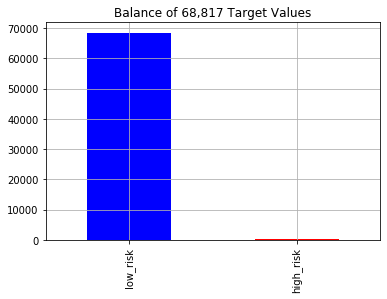

In [93]:
# Check the balance of our target values
y_vis = y.value_counts()
print(y_vis)
y_vis.plot(kind='bar', title='Balance of 68,817 Target Values', grid=True, color=['blue', 'red'])

In [33]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)

In [37]:
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

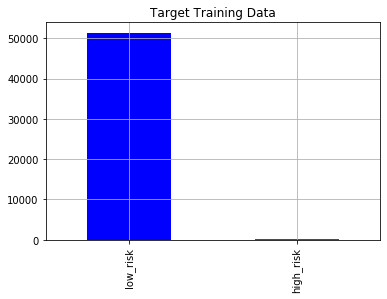

In [94]:
y_train_vis = y_train.value_counts()
y_train_vis.plot(kind='bar', title='Target Training Data', grid=True, color=['blue', 'red'])

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [46]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'low_risk': 51366, 'high_risk': 51366})

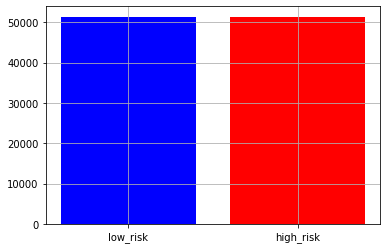

In [95]:
y_res_vis = Counter(y_res)

plt.bar(y_res_vis.keys(), y_res_vis.values(), color=['blue', 'red'])
plt.grid(True)
plt.show()


In [129]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(
                                max_iter=100,
                                random_state=1)
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
classifier.fit(X_res, y_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [131]:
predictions = classifier.predict(X_test)

In [132]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_score_naive = round(balanced_accuracy_score(y_test, predictions),2)*100
print(f"Naive Random Oversampling Balanced Accuracy Score: {balanced_score_naive}%")

Naive Random Oversampling Balanced Accuracy Score: 70.0%


In [133]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(y_test, predictions)
cm

array([[   71,    30],
       [ 5262, 11842]], dtype=int64)

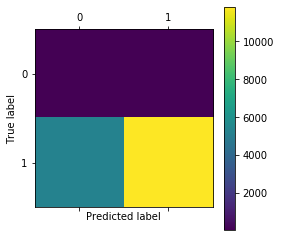

In [134]:
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [135]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
results = classification_report_imbalanced(y_test, predictions)
print("Imbalanced Classification Report, Naive Random Oversampling")
print(results)

Imbalanced Classification Report, Naive Random Oversampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.70      0.69      0.03      0.70      0.49       101
   low_risk       1.00      0.69      0.70      0.82      0.70      0.49     17104

avg / total       0.99      0.69      0.70      0.81      0.70      0.49     17205



### SMOTE Oversampling

In [136]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, ratio=1.0).fit_resample(
    X_train, y_train
)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

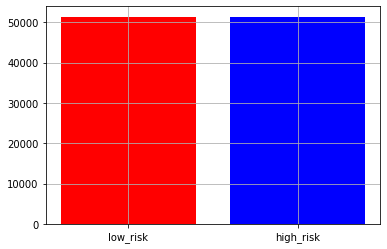

In [137]:
y_resampled_vis = Counter(y_resampled)

plt.bar(y_resampled_vis.keys(), y_resampled_vis.values(), color=['red', 'blue'])
plt.grid(True)
plt.show()

In [138]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_score_smote = round(balanced_accuracy_score(y_test, y_pred),2)*100
print(f"SMOTE Oversampling Balanced Accuracy Score: {balanced_score_smote}%")

SMOTE Oversampling Balanced Accuracy Score: 72.0%


In [140]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[   72,    29],
       [ 4579, 12525]], dtype=int64)

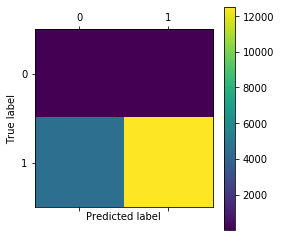

In [141]:
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [142]:
# Print the imbalanced classification report
results = (classification_report_imbalanced(y_test, y_pred))
print("Imbalanced Classification Report, SMOTE Oversampling")
print(results)

Imbalanced Classification Report, SMOTE Oversampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.71      0.73      0.03      0.72      0.52       101
   low_risk       1.00      0.73      0.71      0.84      0.72      0.52     17104

avg / total       0.99      0.73      0.71      0.84      0.72      0.52     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [143]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'high_risk': 246, 'low_risk': 246})

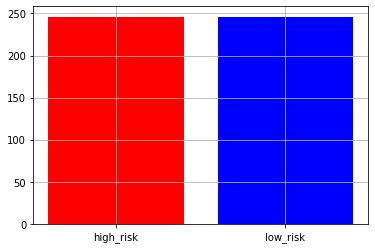

In [144]:
y_resampled_cluster_vis = Counter(y_resampled)

plt.bar(y_resampled_cluster_vis.keys(), y_resampled_cluster_vis.values(), color=['red', 'blue'])
plt.grid(True)
plt.show()

In [145]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [146]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred_under = model.predict(X_test)
balanced_score_under = round(balanced_accuracy_score(y_test, y_pred_under),2)*100
print(f"Cluster Centroids Undersampling Balanced Accuracy Score: {balanced_score_under}%")


Cluster Centroids Undersampling Balanced Accuracy Score: 65.0%


In [147]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_under)

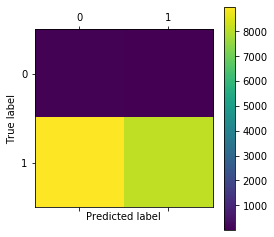

In [148]:
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [149]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
results = (classification_report_imbalanced(y_test, y_pred_under))
print("Imbalanced Classification Report, Cluster Centroids Undersampling")
print(results)

Imbalanced Classification Report, Cluster Centroids Undersampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.82      0.47      0.02      0.62      0.40       101
   low_risk       1.00      0.47      0.82      0.64      0.62      0.38     17104

avg / total       0.99      0.48      0.82      0.64      0.62      0.38     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [150]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 51359, 'low_risk': 46660})

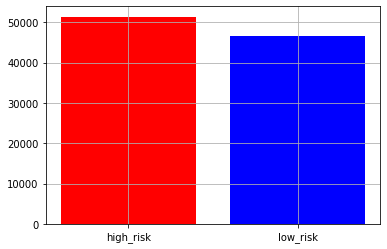

In [151]:
y_resampled_smoteenn = Counter(y_resampled)

plt.bar(y_resampled_smoteenn.keys(), y_resampled_smoteenn.values(), color=['red', 'blue'])
plt.grid(True)
plt.show()

In [152]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [153]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
balanced_score_smoteenn = round(balanced_accuracy_score(y_test, y_pred),2)*100
print(f"SMOTEENN Combination Balanced Accuracy Score: {balanced_score_smoteenn}%")

SMOTEENN Combination Balanced Accuracy Score: 69.0%


In [154]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[   75,    26],
       [ 6040, 11064]], dtype=int64)

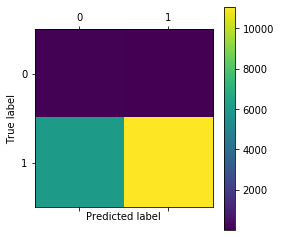

In [155]:
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [156]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
results = (classification_report_imbalanced(y_test, y_pred))
print("Imbalanced Classification Report, SMOTEENN Combination")
print(results)

Imbalanced Classification Report, SMOTEENN Combination
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.74      0.65      0.02      0.69      0.48       101
   low_risk       1.00      0.65      0.74      0.78      0.69      0.48     17104

avg / total       0.99      0.65      0.74      0.78      0.69      0.48     17205

